In [47]:
import pandas as pd
import numpy as np
import time 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns

from sklearn.tree import export_graphviz
import graphviz

In [48]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [49]:
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
train = train.drop(columns = ['global_category','interaction_type','command'])
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
test = test.drop(columns = ['global_category','interaction_type','command'])

In [50]:
x_train, y_train = train.drop(columns=['device']), train['device']
x_test, y_test = test.drop(columns=['device']), test['device']

In [51]:
print('70.13% Train y 29.87% Test: ')
print(f'Train : {train.shape}')
print(f'Test : {test.shape}')

70.13% Train y 29.87% Test: 
Train : (160933, 42)
Test : (68546, 42)


In [14]:
#Para no usar cross validation(Tarda mucho y ofrece peores resultados)
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

# RANDOM FOREST

## Sin hiperparámetros:

In [6]:
RF_model = RandomForestClassifier()

In [7]:
start = time.time()
RF_model.fit(x_train, y_train)
stop = time.time()

In [8]:
print(f'RF execution time:{stop - start}s')
print(f'Train accuracy : {RF_model.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model.score(x_test, y_test): .3f}')

RF execution time:30.74900245666504s
Train accuracy :  1.000
Test accuracy :  0.948


### Matriz de confusión:

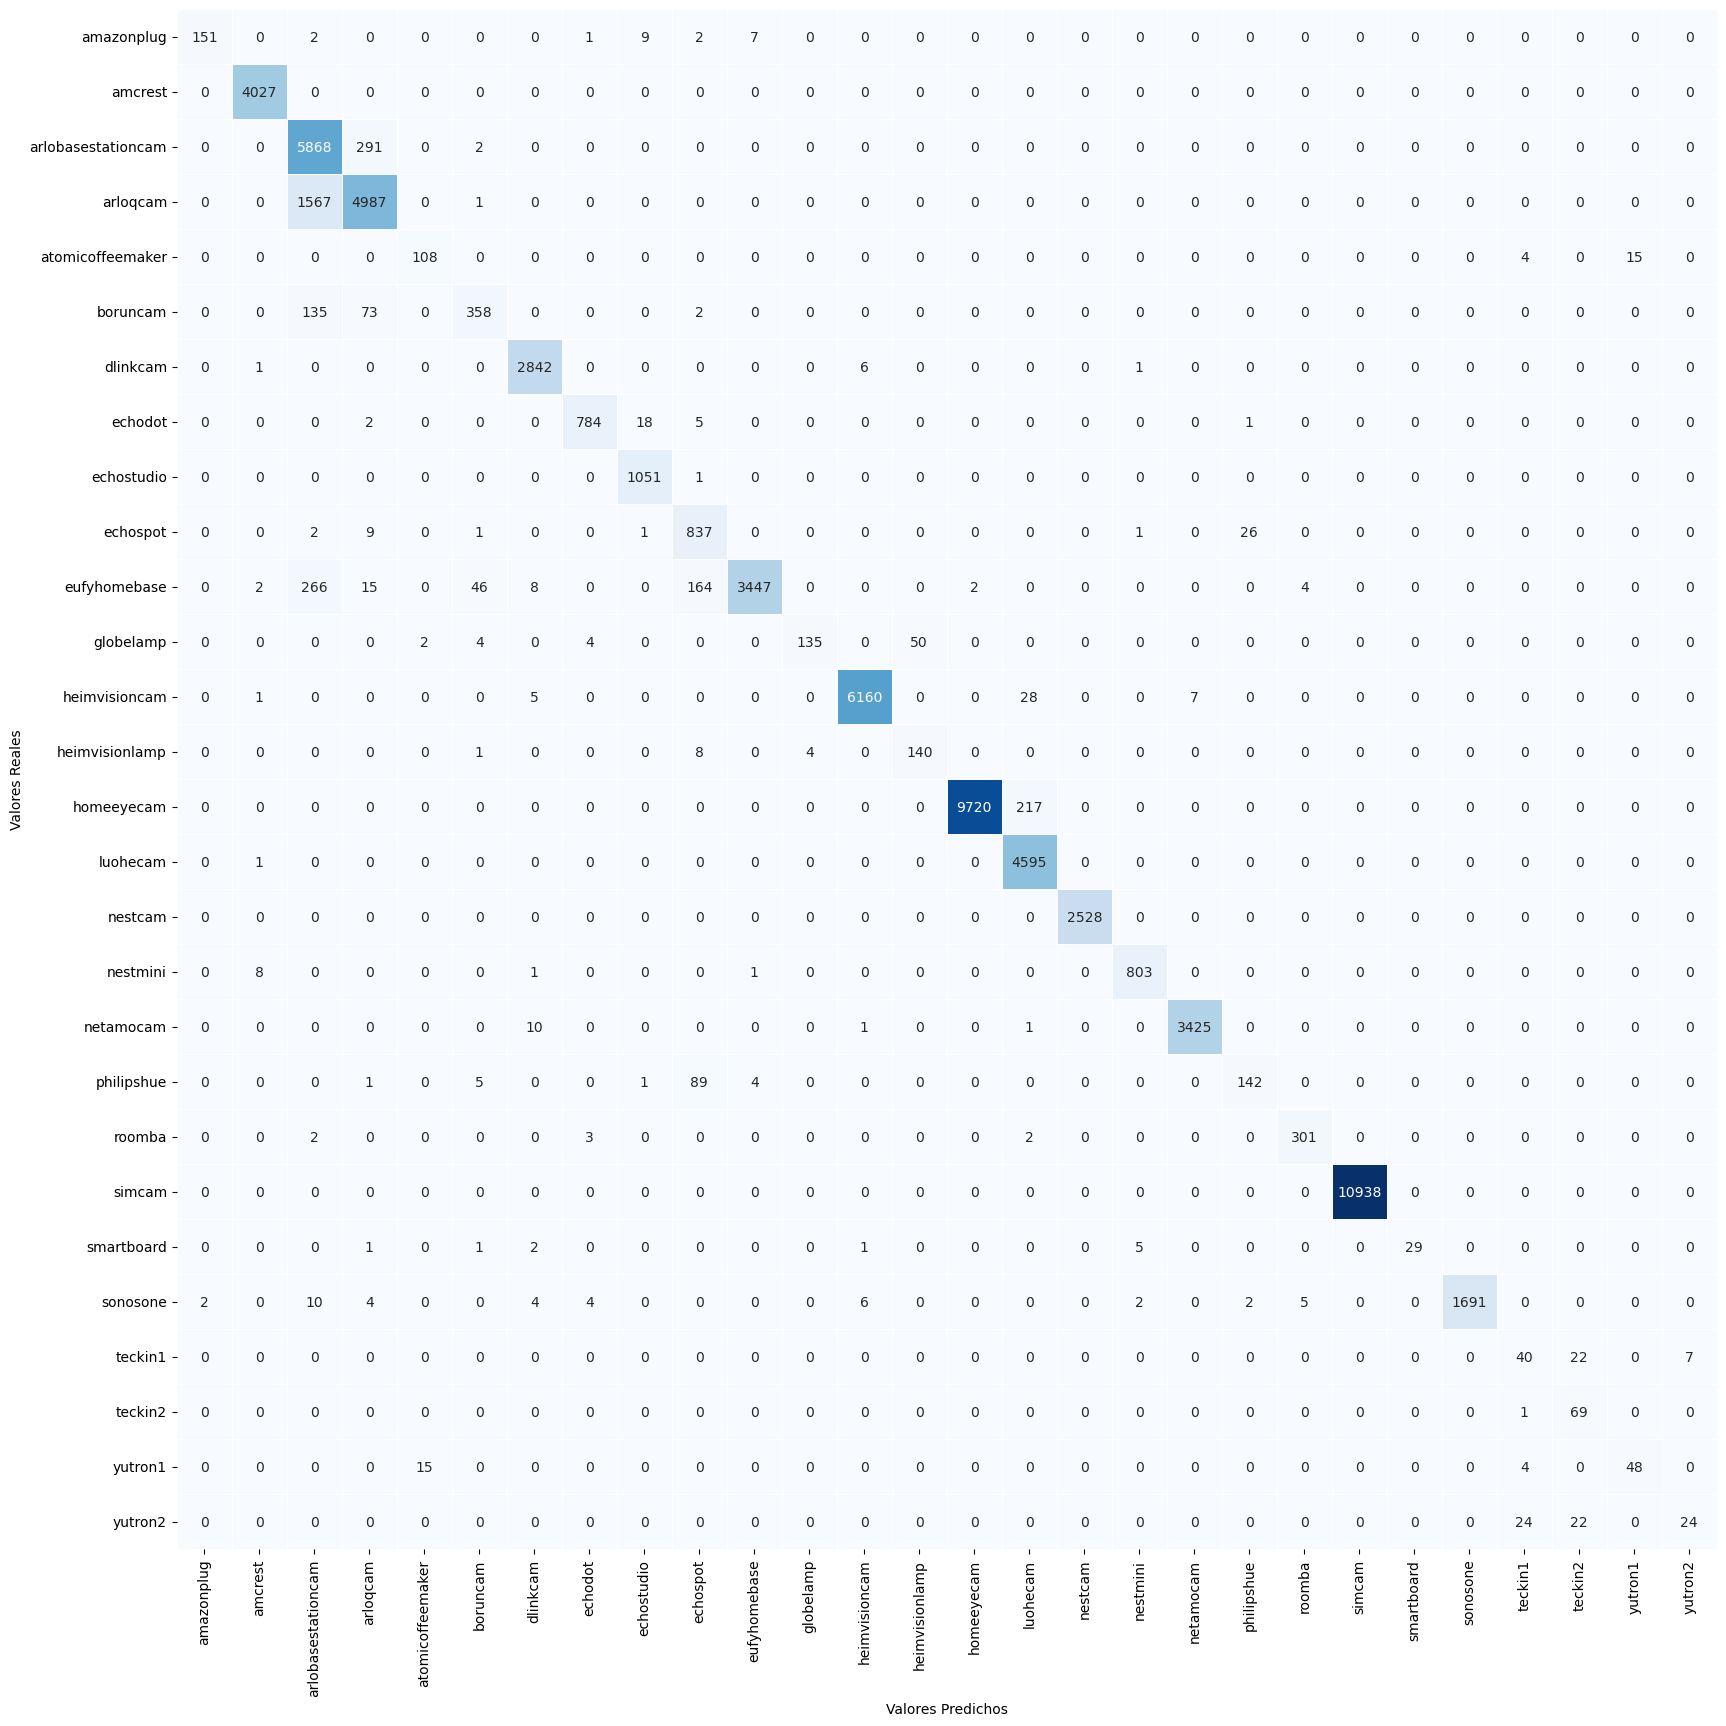

In [10]:
y_pred_RF1 = RF_model.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF1)

class_names = ['amazonplug','amcrest','arlobasestationcam', 'arloqcam', 'atomicoffeemaker', 'boruncam',
               'dlinkcam', 'echodot', 'echostudio', 'echospot', 'eufyhomebase', 'globelamp', 'heimvisioncam', 
               'heimvisionlamp', 'homeeyecam', 'luohecam', 'nestcam', 'nestmini','netamocam', 'philipshue',
               'roomba', 'simcam', 'smartboard', 'sonosone', 'teckin1','teckin2','yutron1', 'yutron2']


sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

### F1_Score, recall y precision:

In [12]:
print(metrics.classification_report(y_test, y_pred_RF1))

                    precision    recall  f1-score   support

        amazonplug       0.99      0.89      0.94       172
           amcrest       1.00      1.00      1.00      4027
arlobasestationcam       0.75      0.95      0.84      6161
          arloqcam       0.92      0.76      0.84      6555
  atomicoffeemaker       0.85      0.85      0.85       127
          boruncam       0.85      0.59      0.70       568
          dlinkcam       0.99      1.00      0.99      2850
           echodot       0.99      0.97      0.98       810
          echospot       0.97      1.00      0.98      1052
        echostudio       0.75      0.96      0.84       877
      eufyhomebase       1.00      0.88      0.93      3954
         globelamp       0.97      0.79      0.88       195
     heimvisioncam       1.00      0.99      1.00      6201
    heimvisionlamp       0.86      0.97      0.91       153
        homeeyecam       1.00      0.97      0.98      9937
          luohecam       0.93      1.00

# Definición de todos los hiperparámetros:

In [17]:
# Número de árboles
n_estimators = [int(x) for x in np.linspace(start=10, stop=150, num=15)]
# Criterio de creación de los árboles. Es la función que mide la calidad de las "split".
criterion = ["gini", "entropy"]
#Para fijar la profundidad máxima de los árboles
max_depth = [int(x) for x in np.linspace(start=1, stop=15, num=15)] 
# Número de características a tener en cuenta para cada árbol
max_features = ['auto', 'sqrt', 'log2']
# Mínimo número de muestras que se requieren para dividir un nodo
min_samples_split = [int(x) for x in np.linspace(start=1, stop=20, num=20)]
# Mínimo número de muestras que se requieren en cada hoja
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=20, num=20)]
# True -> Muestreo Aleatorio
# False -> Se utiliza el dataset entero para construir cada árbol
bootstrap = [True, False]
# (Out of the bag) Datos que NO vamos a usar para el muestreo. Al activar esto, se usarán dichos datos para testear los árboles
# Solo disponible si bootstrap es True
oob_score = [True, False]
# True -> Reutiliza la solución de la llamada anterior para el fit y para agregar más estimadores al conjunto.
# False -> Realiza un bosque completamente nuevo.
warm_start = [True, False]
# Controla tanto la aleatoriedad del bootstrap (si bootstrap = true),
# como el muestreo de las propiedades a tener en cuenta al buscar la mejor división de cada nodo,
random_state = [int(x) for x in np.linspace(start=1, stop=50, num=50)]
# Pesos asociados a las clases
class_weight = ['balanced', 'balanced_subsample']

# Porcentaje de los datos que vamos a muestrear (si bootstrap es True)
max_samples = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [18]:
param_grid = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_features': max_features,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth}

print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}


# Primera elección con RandomSearchCV:

In [19]:
RF_RandomGrid1 = RandomizedSearchCV(estimator = RF_model,
                                   param_distributions = param_grid,
                                   cv = 5, verbose=2, n_jobs = 4)

In [20]:
start = time.time()
RF_RandomGrid1.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [21]:
RF_RandomGrid1.best_params_

{'n_estimators': 130,
 'min_samples_split': 18,
 'min_samples_leaf': 14,
 'max_features': 'auto',
 'max_depth': 14,
 'criterion': 'entropy'}

In [22]:
print(f"RandomizedSearch RF time: {stop - start}s")
print(f'Train accuracy : {RF_RandomGrid1.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_RandomGrid1.score(x_test, y_test): .3f}')

RandomizedSearch RF time: 268.3375346660614s
Train accuracy :  0.986
Test accuracy :  0.948


In [23]:
RF_model2 = RandomForestClassifier(n_estimators=130,
                                   criterion='entropy',
                                   min_samples_split=18, 
                                   min_samples_leaf=14,
                                   max_features='auto',
                                   max_depth=14)

start = time.time()
RF_model2.fit(x_train, y_train)
stop = time.time()

In [24]:
print(f"RF training time: {stop - start}s")
print(f'Train accuracy : {RF_model2.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model2.score(x_test, y_test): .3f}')

RF training time: 71.99246597290039s
Train accuracy :  0.987
Test accuracy :  0.952


In [29]:
RF_model2.get_depth()

AttributeError: 'RandomForestClassifier' object has no attribute 'get_depth'

## Matriz de confusión:

In [16]:
y_pred_RF2 = RF_model2.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF2)
normalized_matrix = cm / cm.sum(axis=1, keepdims=True)

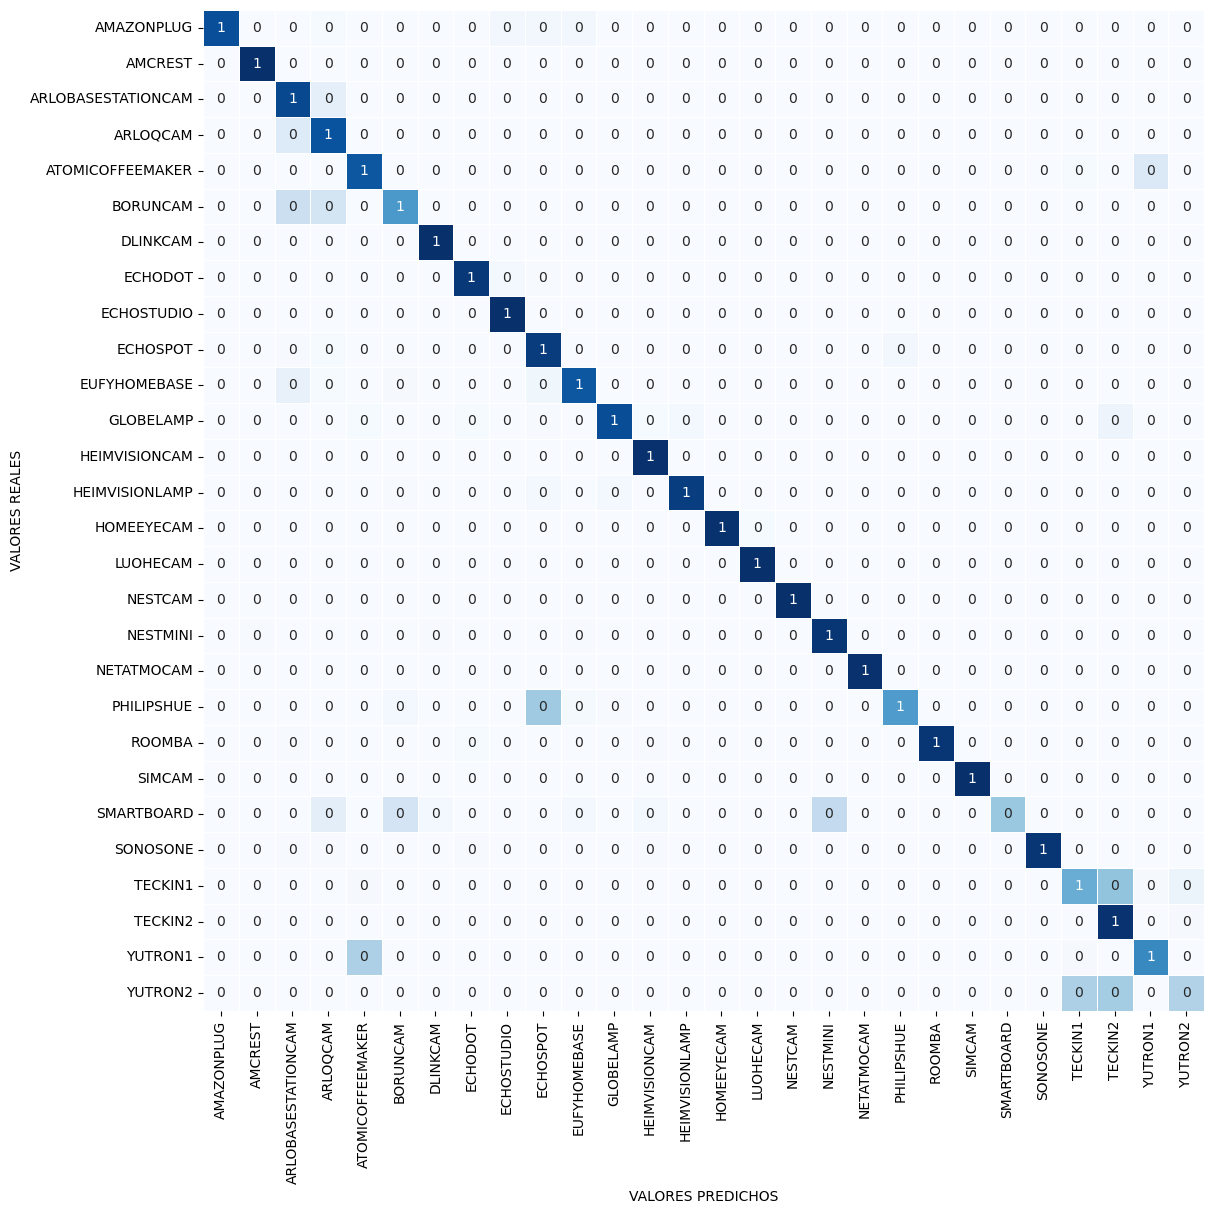

In [24]:
class_names = ['AMAZONPLUG','AMCREST','ARLOBASESTATIONCAM', 'ARLOQCAM', 'ATOMICOFFEEMAKER', 'BORUNCAM',
               'DLINKCAM', 'ECHODOT', 'ECHOSTUDIO', 'ECHOSPOT', 'EUFYHOMEBASE', 'GLOBELAMP', 'HEIMVISIONCAM', 
               'HEIMVISIONLAMP', 'HOMEEYECAM', 'LUOHECAM', 'NESTCAM', 'NESTMINI','NETATMOCAM', 'PHILIPSHUE',
               'ROOMBA', 'SIMCAM', 'SMARTBOARD', 'SONOSONE', 'TECKIN1','TECKIN2','YUTRON1', 'YUTRON2']


sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(13, 13)

plt.ylabel('VALORES REALES')
plt.xlabel('VALORES PREDICHOS')
plt.show()

In [1]:
print(metrics.classification_report(y_test, y_pred_RF))

NameError: name 'metrics' is not defined

In [45]:
RF_model3 =  RandomForestClassifier(n_estimators=110,
                                   criterion='entropy',
                                   min_samples_split=2, 
                                   min_samples_leaf=1,
                                   max_features='auto',
                                   max_depth=14)

start = time.time()
RF_model3.fit(x_train, y_train)
stop = time.time()

In [46]:
print(f"RF training time: {stop - start}s")
print(f'Train accuracy : {RF_model3.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model3.score(x_test, y_test): .3f}')

RF training time: 64.73568630218506s
Train accuracy :  0.993
Test accuracy :  0.951


## Matriz de confusión:

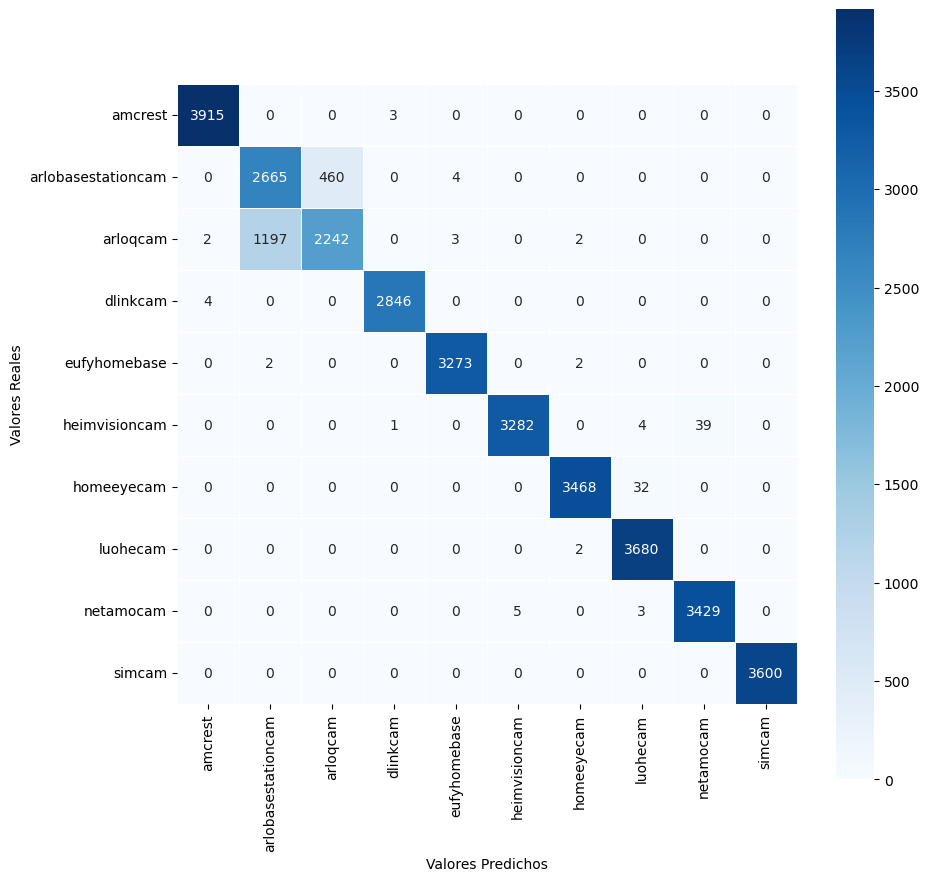

In [62]:
y_pred_RF3 = RF_model3.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF3)

class_names = ['amazonplug','amcrest','arlobasestationcam', 'arloqcam', 'atomicoffeemaker', 'boruncam',
               'dlinkcam', 'echodot', 'echostudio', 'echospot', 'eufyhomebase', 'globelamp', 'heimvisioncam', 
               'heimvisionlamp', 'homeeyecam', 'luohecam', 'nestcam', 'nestmini','netamocam', 'philipshue',
               'roomba', 'simcam', 'smartboard', 'sonosone', 'teckin1','teckin2','yutron1', 'yutron2']


sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues')

fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [63]:
print(metrics.classification_report(y_test, y_pred_RF))

                    precision    recall  f1-score   support

           amcrest       1.00      1.00      1.00      3918
arlobasestationcam       0.69      0.85      0.76      3129
          arloqcam       0.83      0.65      0.73      3446
          dlinkcam       1.00      1.00      1.00      2850
      eufyhomebase       1.00      1.00      1.00      3277
     heimvisioncam       1.00      0.99      0.99      3326
        homeeyecam       1.00      0.99      0.99      3500
          luohecam       0.99      1.00      0.99      3682
        netatmocam       0.99      1.00      0.99      3437
            simcam       1.00      1.00      1.00      3600

          accuracy                           0.95     34165
         macro avg       0.95      0.95      0.95     34165
      weighted avg       0.95      0.95      0.95     34165



# DECISION TREE

# Sin hiperparámetros

In [8]:
dt = DecisionTreeClassifier() #Instanciamos

start=time.time()
dt.fit(x_train, y_train)
stop=time.time()

In [9]:
print(f"DT training time: {stop - start}s")
print(f'Train accuracy : {dt.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt.score(x_test, y_test): .3f}')

DT training time: 3.1983840465545654s
Train accuracy :  1.000
Test accuracy :  0.806


## Matriz de confusión:

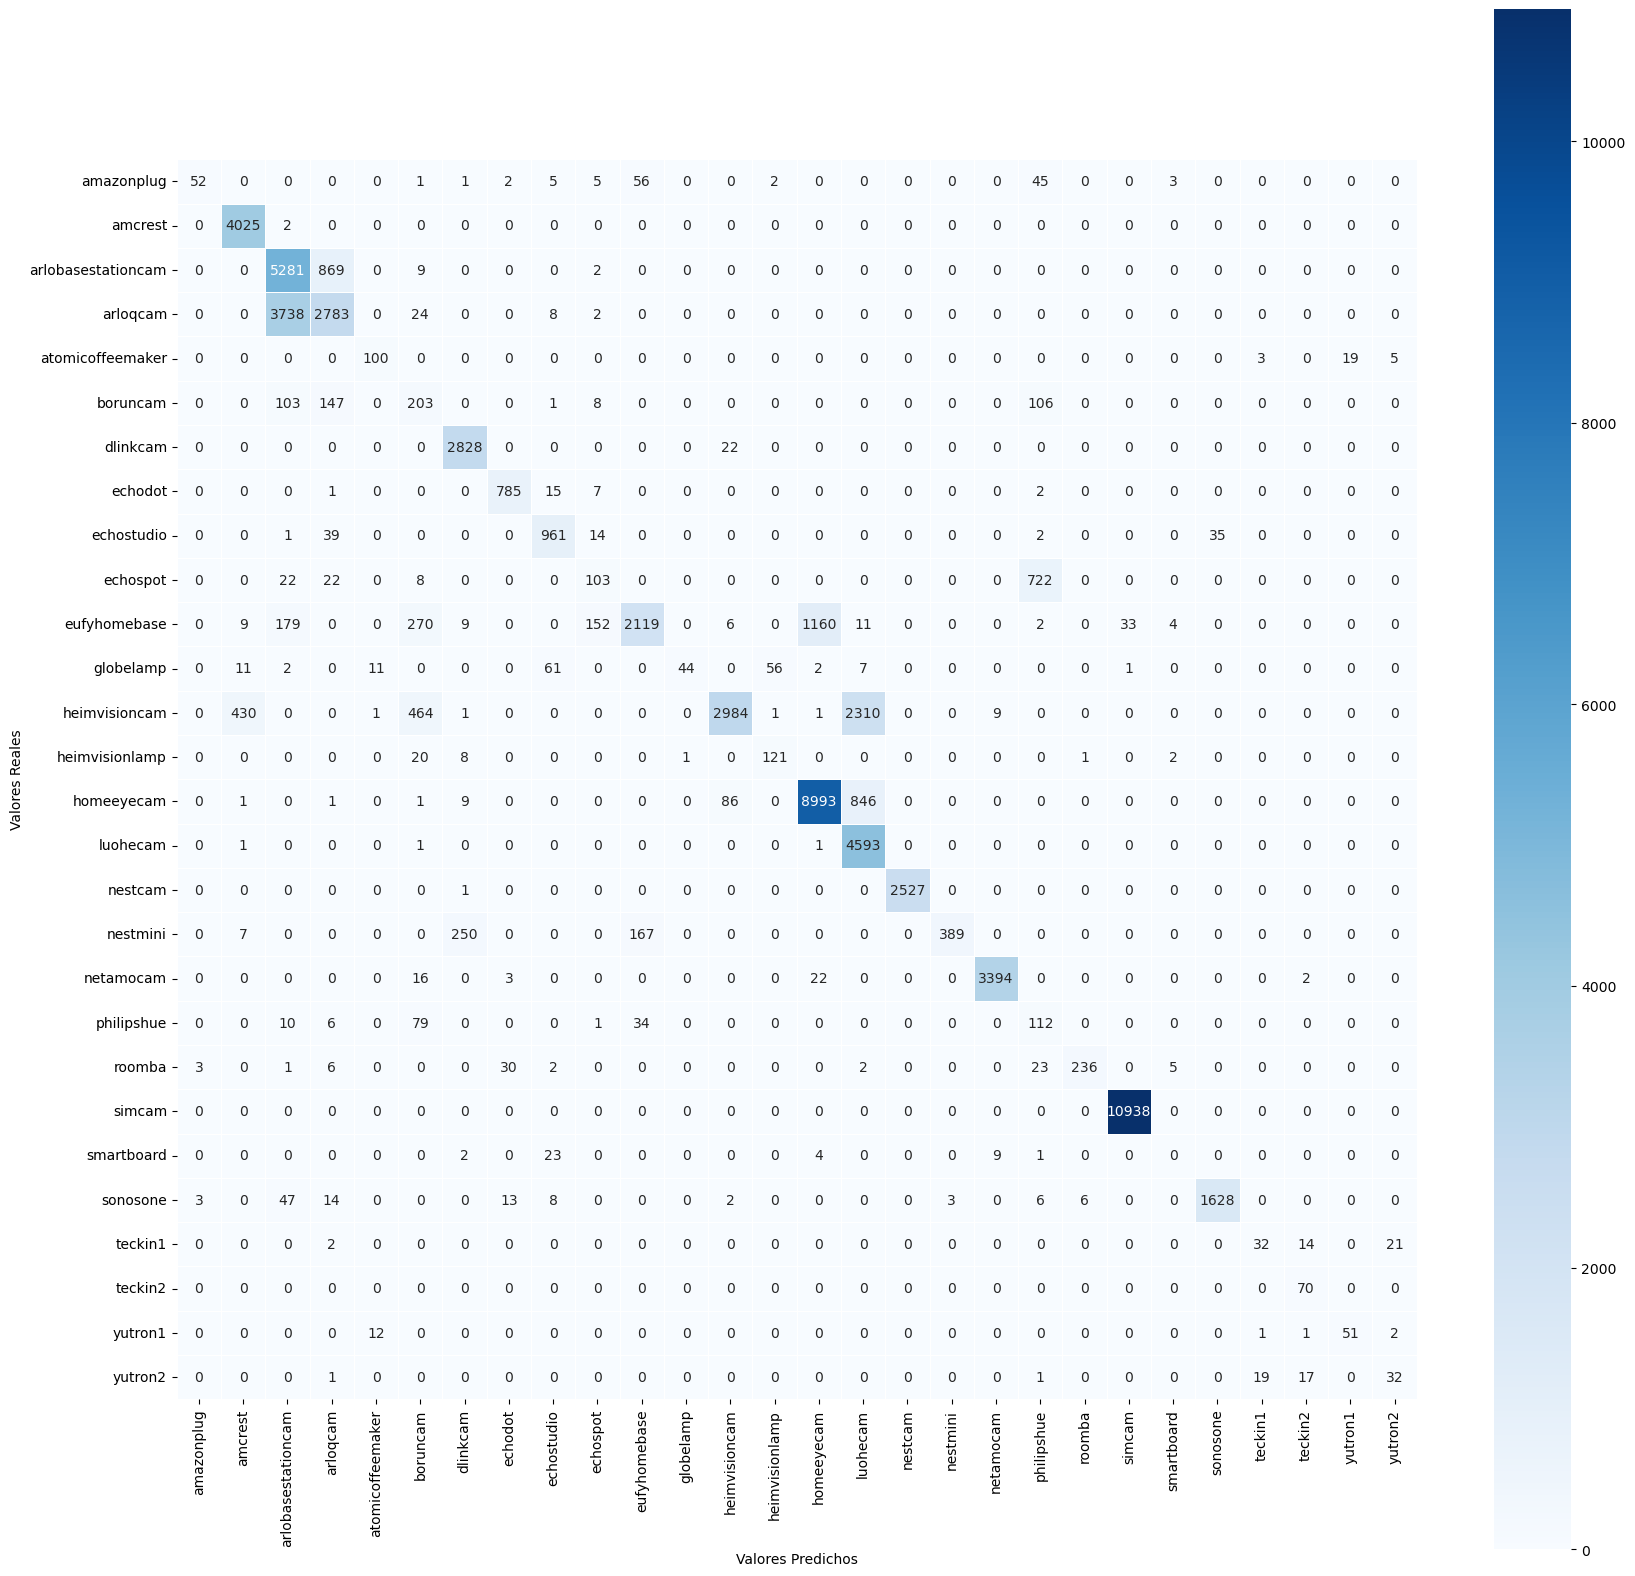

In [44]:
#Guardamos la predicción de Random Forest
y_pred_DT = dt.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_DT)

class_names = ['amazonplug','amcrest','arlobasestationcam', 'arloqcam', 'atomicoffeemaker', 'boruncam',
               'dlinkcam', 'echodot', 'echostudio', 'echospot', 'eufyhomebase', 'globelamp', 'heimvisioncam', 
               'heimvisionlamp', 'homeeyecam', 'luohecam', 'nestcam', 'nestmini','netamocam', 'philipshue',
               'roomba', 'simcam', 'smartboard', 'sonosone', 'teckin1','teckin2','yutron1', 'yutron2']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues')

fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [45]:
print(metrics.classification_report(y_test, y_pred_DT))

                    precision    recall  f1-score   support

        amazonplug       0.90      0.30      0.45       172
           amcrest       0.90      1.00      0.95      4027
arlobasestationcam       0.56      0.86      0.68      6161
          arloqcam       0.72      0.42      0.53      6555
  atomicoffeemaker       0.81      0.79      0.80       127
          boruncam       0.19      0.36      0.24       568
          dlinkcam       0.91      0.99      0.95      2850
           echodot       0.94      0.97      0.96       810
          echospot       0.89      0.91      0.90      1052
        echostudio       0.35      0.12      0.18       877
      eufyhomebase       0.89      0.54      0.67      3954
         globelamp       0.98      0.23      0.37       195
     heimvisioncam       0.96      0.48      0.64      6201
    heimvisionlamp       0.67      0.79      0.73       153
        homeeyecam       0.88      0.91      0.89      9937
          luohecam       0.59      1.00

# Definición de todos los hiperparámetros:

In [92]:
# Criterio de creación de los árboles. Es la función que mide la calidad de las "split".
criterion = ["gini", "entropy"]
#Para fijar la profundidad máxima de los árboles
max_depth = [int(x) for x in np.linspace(start=1, stop=15, num=15)] 
# Número de características a tener en cuenta para cada árbol
max_features = ['auto', 'sqrt', 'log2', None]
# Mínimo número de muestras que se requieren para dividir un nodo
min_samples_split = [int(x) for x in np.linspace(start=2, stop=10, num=9)]
# Mínimo número de muestras que se requieren en cada hoja
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=10, num=10)]
#Estrategia usada para dividir los nodos
splitter = ['best', 'random']
max_leaf_nodes = [int(x) for x in np.linspace(start=1, stop=40, num=40)]

In [100]:
param_grid3 = {'criterion': criterion,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'splitter': splitter,
              'max_depth': max_depth,
              'max_features': max_features}

DT_RandomGrid = RandomizedSearchCV(estimator = dt,
                                   param_distributions = param_grid3,
                                   cv = 5, verbose=2, n_jobs = 4)

start = time.time()
DT_RandomGrid.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [101]:
print(f"RandomizedSearch DT time: {stop - start}s")
print(f'Train accuracy : {DT_RandomGrid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {DT_RandomGrid.score(x_test, y_test): .3f}')

RandomizedSearch DT time: 25.37718963623047s
Train accuracy :  0.989
Test accuracy :  0.887


In [102]:
DT_RandomGrid.best_params_

{'splitter': 'best',
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_features': None,
 'max_depth': 13,
 'criterion': 'entropy'}

In [135]:
dt1 = DecisionTreeClassifier(criterion = 'entropy', 
                             splitter='best',
                             min_samples_split = 6, 
                             min_samples_leaf = 5,
                             max_features = None,
                             max_depth = 13)

start = time.time()
dt1.fit(x_train, y_train)
stop = time.time()

In [136]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt1.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt1.score(x_test, y_test): .3f}')

Training time: 4.299748659133911s
Train accuracy :  0.989
Test accuracy :  0.887


# Introduciendo parámetros manualmente:

In [140]:
#Sacamos los parámetros del árbol sin hiperparámetros, ya que nos ha salido con buena precisión.
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## Introducimos los parámetros obtenidos manualmente:

In [52]:
dt1 = DecisionTreeClassifier(criterion = 'entropy', 
                             splitter='best',
                             min_samples_split = 6, 
                             min_samples_leaf = 5,
                             max_features = None,
                             max_depth = 13)

start = time.time()
dt1.fit(x_train, y_train)
stop = time.time()

In [53]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt1.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt1.score(x_test, y_test): .3f}')

Training time: 4.362702369689941s
Train accuracy :  0.989
Test accuracy :  0.888


In [67]:
dt1.get_depth()

13

In [371]:
dt1.get_n_leaves()

768

## Matriz de confusión:

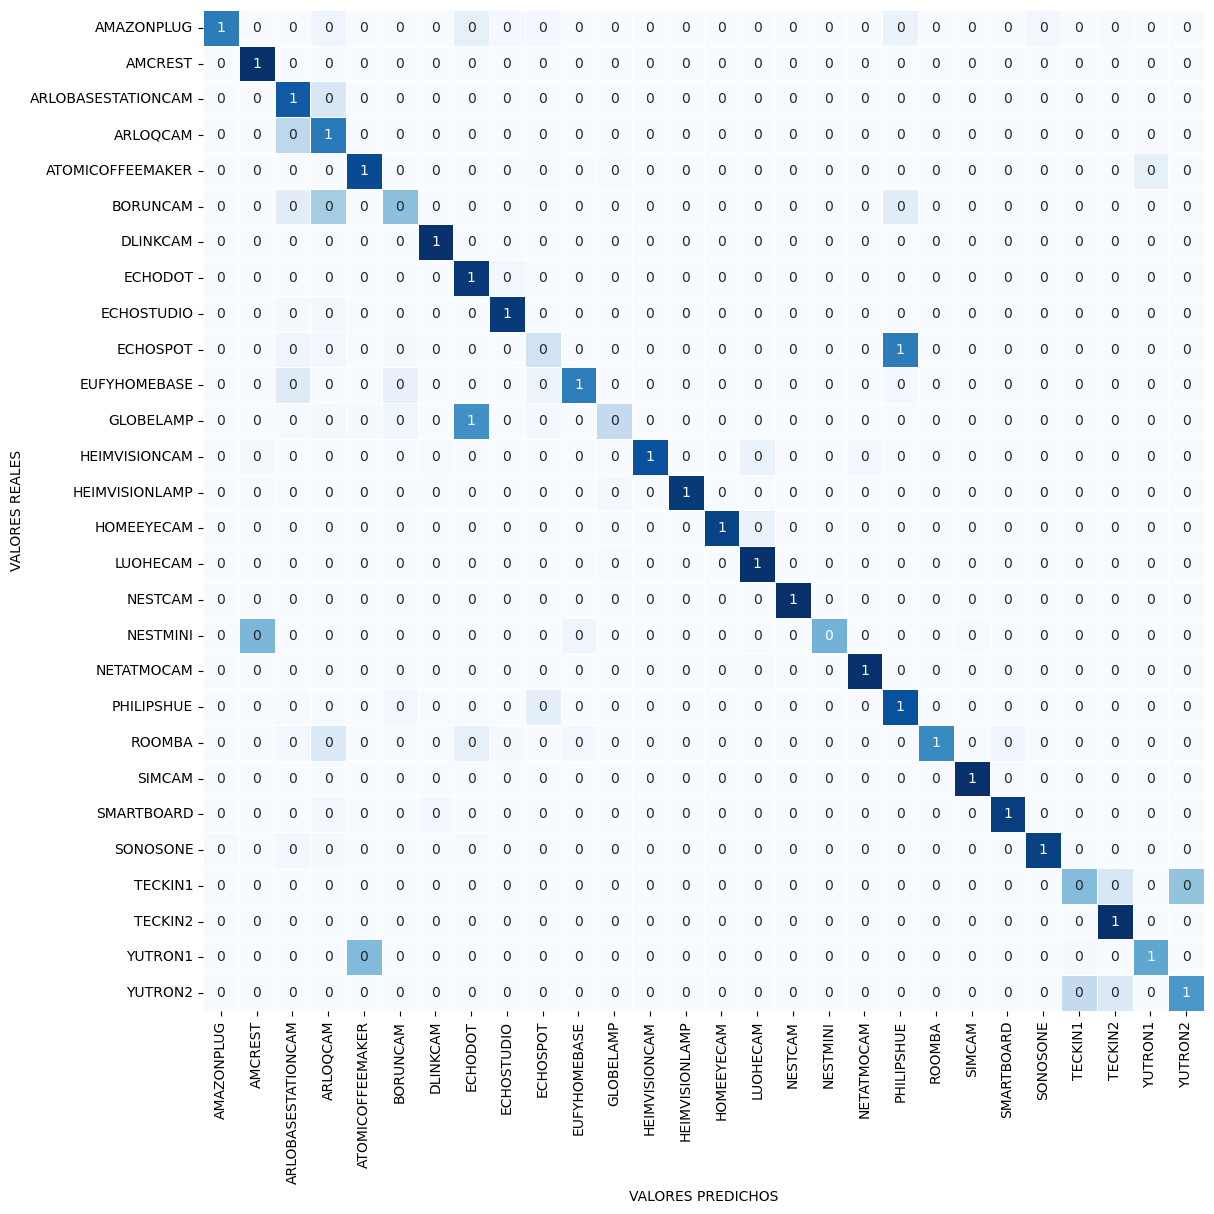

In [55]:
y_pred_DT1 = dt1.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_DT1)
cm = metrics.confusion_matrix(y_test, y_pred_DT1)
normalized_matrix = cm / cm.sum(axis=1, keepdims=True)

class_names = ['AMAZONPLUG','AMCREST','ARLOBASESTATIONCAM', 'ARLOQCAM', 'ATOMICOFFEEMAKER', 'BORUNCAM',
               'DLINKCAM', 'ECHODOT', 'ECHOSTUDIO', 'ECHOSPOT', 'EUFYHOMEBASE', 'GLOBELAMP', 'HEIMVISIONCAM', 
               'HEIMVISIONLAMP', 'HOMEEYECAM', 'LUOHECAM', 'NESTCAM', 'NESTMINI','NETATMOCAM', 'PHILIPSHUE',
               'ROOMBA', 'SIMCAM', 'SMARTBOARD', 'SONOSONE', 'TECKIN1','TECKIN2','YUTRON1', 'YUTRON2']


sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(13, 13)

plt.ylabel('VALORES REALES')
plt.xlabel('VALORES PREDICHOS')
plt.show()

In [12]:
print(metrics.classification_report(y_test, y_pred_DT1))

                    precision    recall  f1-score   support

        amazonplug       0.92      0.70      0.80       172
           amcrest       0.90      1.00      0.95      4027
arlobasestationcam       0.67      0.84      0.75      6161
          arloqcam       0.78      0.71      0.74      6555
  atomicoffeemaker       0.78      0.91      0.84       127
          boruncam       0.42      0.45      0.43       568
          dlinkcam       0.98      0.99      0.99      2850
           echodot       0.81      0.97      0.88       810
          echospot       0.91      0.96      0.93      1052
        echostudio       0.37      0.19      0.25       877
      eufyhomebase       0.98      0.70      0.82      3954
         globelamp       0.38      0.26      0.31       195
     heimvisioncam       1.00      0.87      0.93      6201
    heimvisionlamp       0.96      0.96      0.96       153
        homeeyecam       1.00      0.93      0.96      9937
          luohecam       0.80      0.99

In [374]:
feature_names = x_train.columns
feature_names

Index(['L4_tcp', 'L4_udp', 'L7_http', 'L7_https', 'port_class_src',
       'port_class_dst', 'pck_size', 'ethernet_frame_size', 'ttl',
       'total_length', 'protocol', 'DNS_count', 'NTP_count', 'ARP_count',
       'cnt', 'L3_ip_dst_count', 'most_freq_prot', 'sum_et', 'min_et',
       'max_et', 'med_et', 'average_et', 'skew_et', 'kurt_et', 'var', 'q3',
       'q1', 'iqr', 'sum_e', 'min_e', 'max_e', 'med', 'average', 'skew_e',
       'kurt_e', 'var_e', 'q3_e', 'q1_e', 'iqr_e', 'inter_arrival_time',
       'time_since_previously_displayed_frame'],
      dtype='object')

In [375]:
dt1.feature_importances_

array([0.00088989, 0.00400558, 0.00158317, 0.00645041, 0.00906435,
       0.00688042, 0.00394018, 0.00416473, 0.02006235, 0.00288056,
       0.00155383, 0.0454788 , 0.01238269, 0.01651792, 0.02276222,
       0.19304176, 0.23246526, 0.00498805, 0.02426363, 0.03351338,
       0.00905042, 0.00422943, 0.00137925, 0.00457951, 0.00565319,
       0.00791467, 0.01124034, 0.00471209, 0.00583731, 0.14438566,
       0.05490686, 0.02458749, 0.00867601, 0.00247331, 0.00096643,
       0.00503965, 0.03025399, 0.01119162, 0.00380926, 0.00415188,
       0.00807247])

In [376]:
feature_importances = pd.DataFrame(dt1.feature_importances_, index = feature_names).sort_values(0, ascending = False)
feature_importances

,0
most_freq_prot,0.232465
L3_ip_dst_count,0.193042
min_e,0.144386
max_e,0.054907
DNS_count,0.045479
max_et,0.033513
q3_e,0.030254
med,0.024587
min_et,0.024264
cnt,0.022762


<AxesSubplot:>

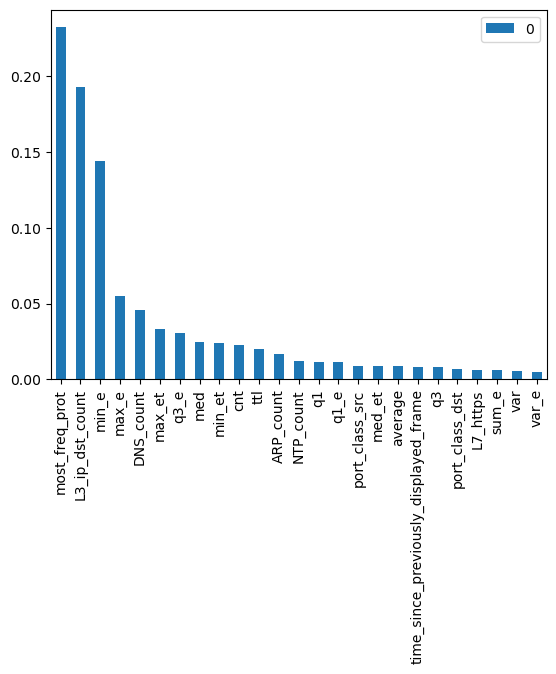

In [377]:
feature_importances.head(25).plot(kind='bar')

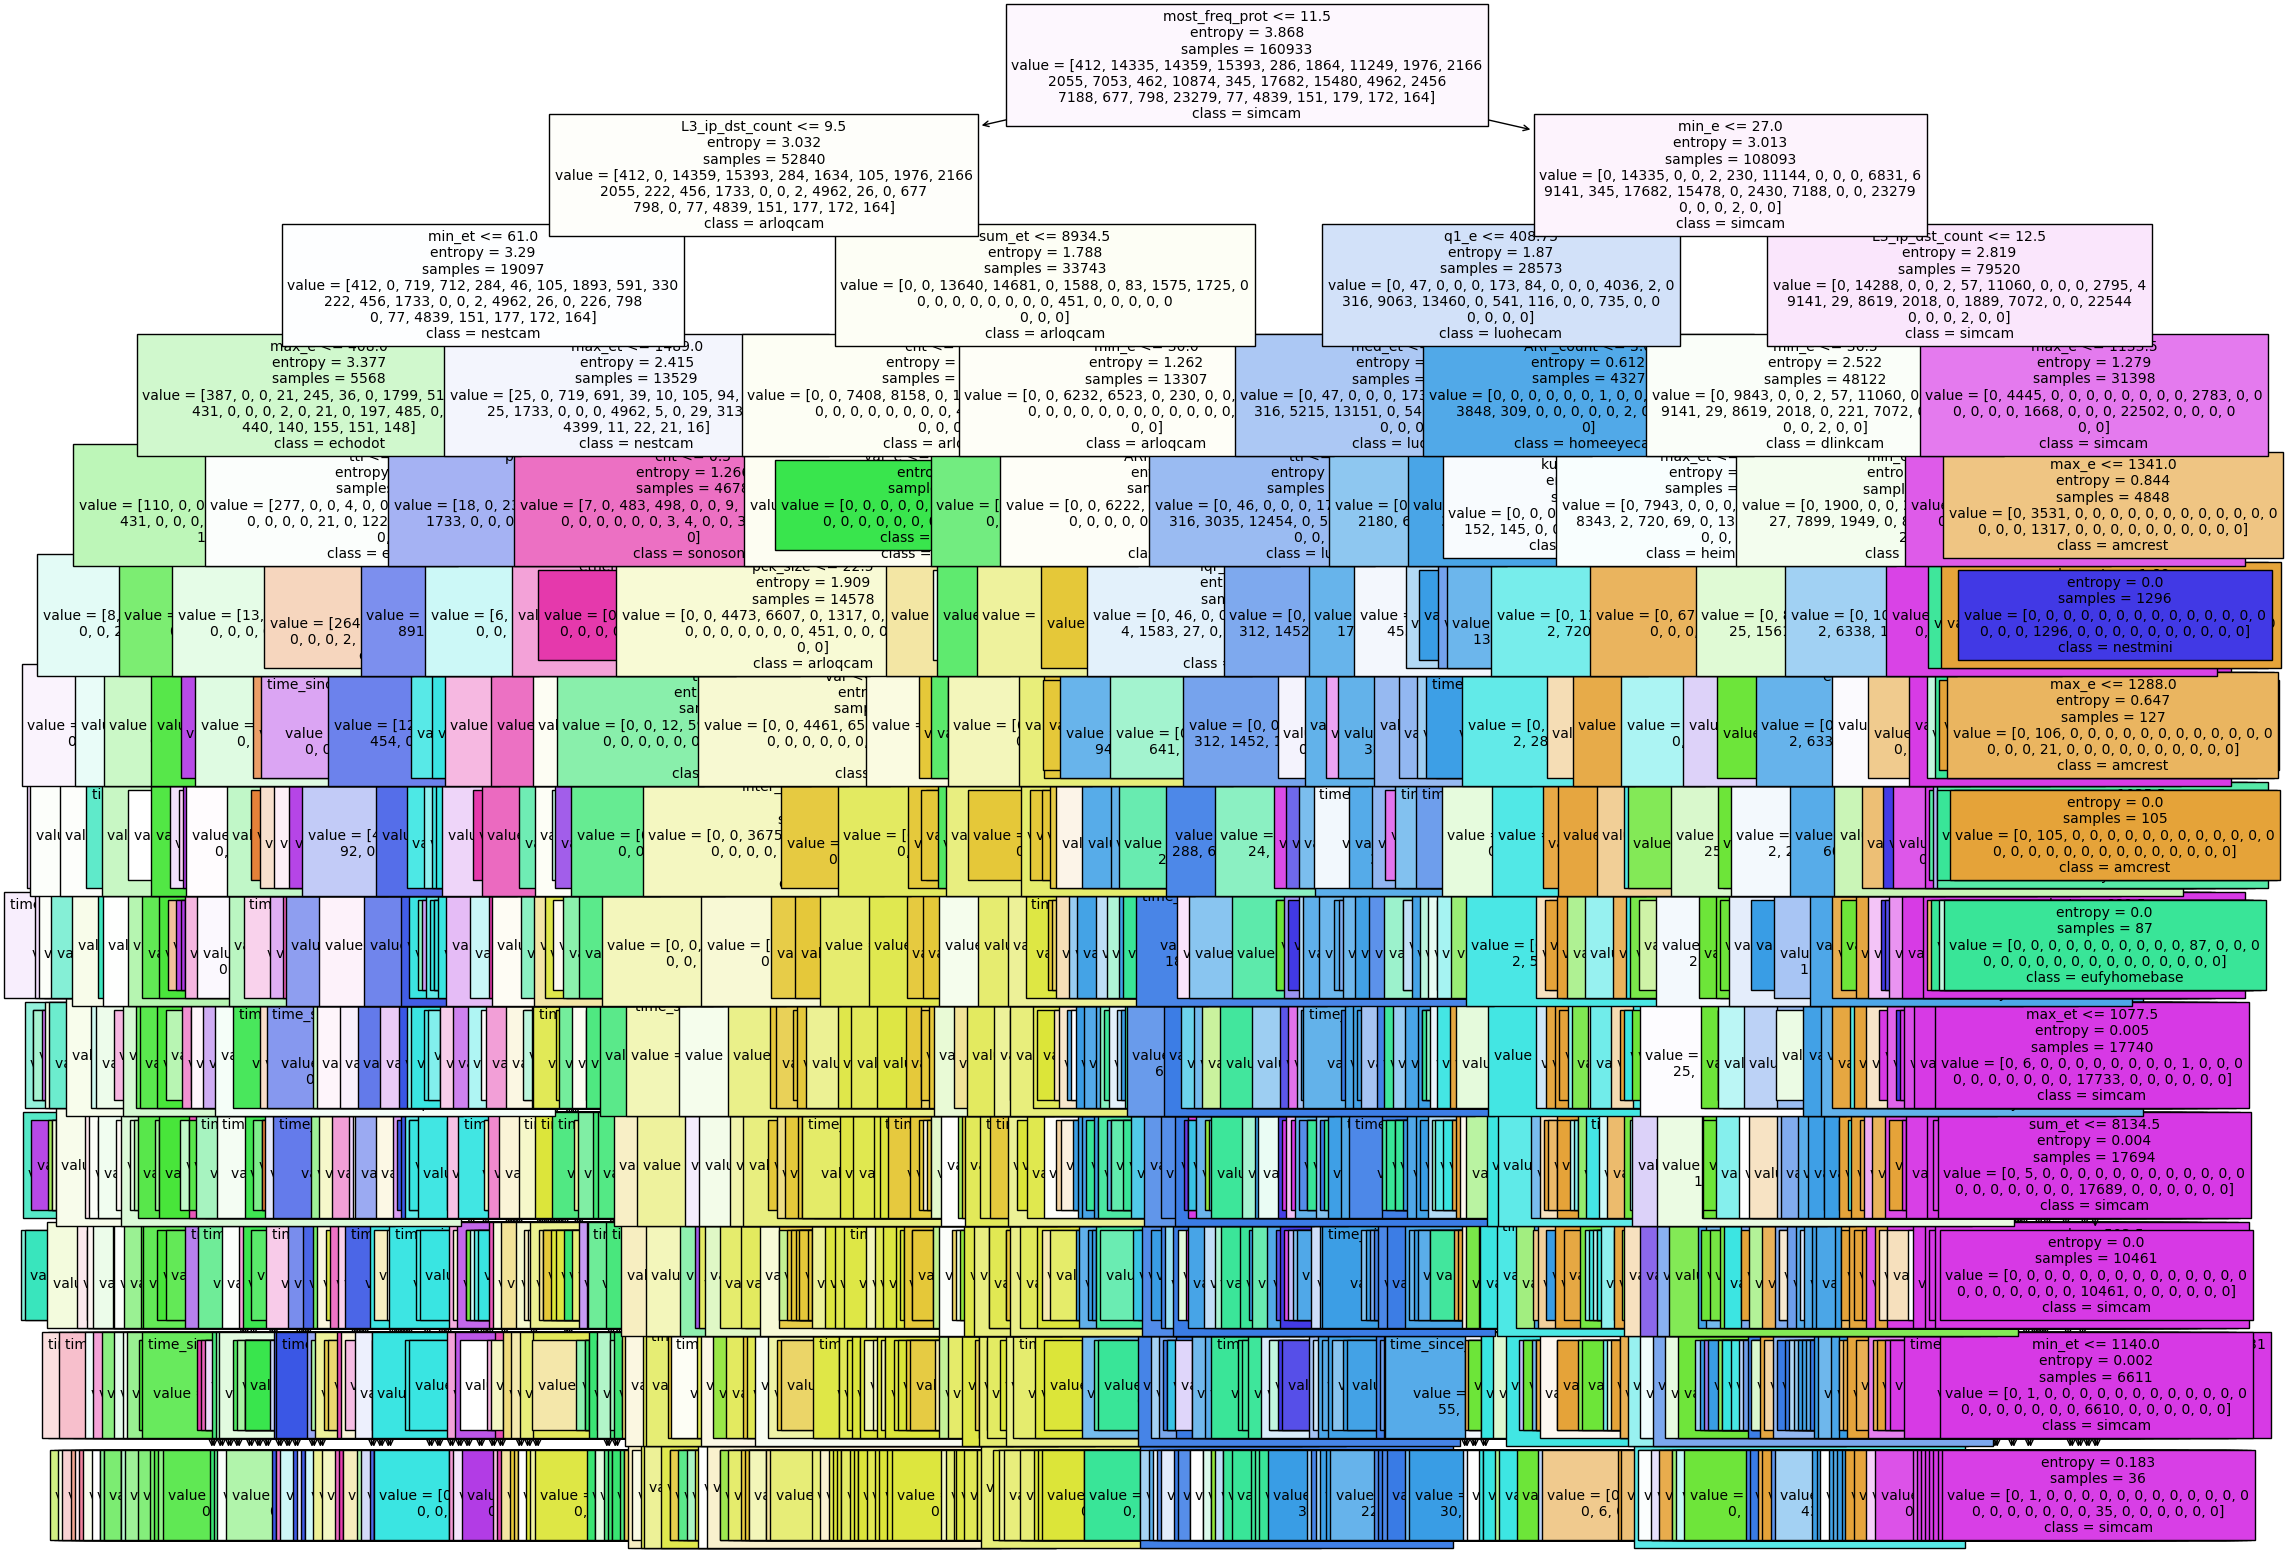

In [378]:
class_names = ['amazonplug','amcrest','arlobasestationcam', 'arloqcam', 'atomicoffeemaker', 'boruncam',
               'dlinkcam', 'echodot', 'echostudio', 'echospot', 'eufyhomebase', 'globelamp', 'heimvisioncam', 
               'heimvisionlamp', 'homeeyecam', 'luohecam', 'nestcam', 'nestmini','netamocam', 'philipshue',
               'roomba', 'simcam', 'smartboard', 'sonosone', 'teckin1','teckin2','yutron1', 'yutron2']


fig = plt.figure(figsize=(25,20))
tree = tree.plot_tree(dt1,
                      feature_names=feature_names,
                      class_names=class_names,
                      filled = True,
                      fontsize = 10)

## Árbol de decisión con las 7 propiedades de mayor peso:

In [384]:
# Seleccionar las columnas deseadas
columnas_deseadas = ['most_freq_prot','L3_ip_dst_count', 'min_e', 'max_e','DNS_count', 'max_et', 'device']
train_nuevo = train[columnas_deseadas]
test_nuevo = test[columnas_deseadas]

In [385]:
train_nuevo

,most_freq_prot,L3_ip_dst_count,min_e,max_e,DNS_count,max_et,device
0,6,2,32,179,0,213,smartboard
1,6,2,32,179,0,213,smartboard
2,6,2,32,179,0,213,smartboard
3,6,2,32,179,0,213,smartboard
4,6,2,0,0,0,213,smartboard
...,...,...,...,...,...,...,...
160928,17,15,12,12,0,731,simcam
160929,17,15,12,12,0,731,simcam
160930,17,15,12,12,0,731,simcam
160931,17,15,12,12,0,731,simcam


In [386]:
x_train_n, y_train_n = train_nuevo.drop(columns=['device']), train_nuevo['device']
x_test_n, y_test_n = test_nuevo.drop(columns=['device']), test_nuevo['device']

In [387]:
dt2 = DecisionTreeClassifier(criterion = 'gini', 
                             splitter='best',
                             min_samples_split = 60, 
                             min_samples_leaf = 20,
                             min_weight_fraction_leaf = 0.0,
                             min_impurity_decrease = 0.0,
                             class_weight = None,
                             max_leaf_nodes = None,
                             max_depth = 7,
                             max_features = None,
                             ccp_alpha = 0.0) #Instanciamos

start = time.time()
dt2.fit(x_train_n, y_train_n)
stop = time.time()

In [388]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt2.score(x_train_n, y_train_n): .3f}')
print(f'Test accuracy : {dt2.score(x_test_n, y_test_n): .3f}')

Training time: 0.3172495365142822s
Train accuracy :  0.878
Test accuracy :  0.786


In [423]:
y_pred_DT2 = dt2.predict(x_test_n)
cm = metrics.confusion_matrix(y_test_n, y_pred_DT2)

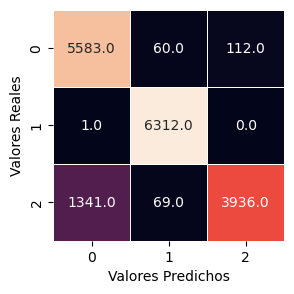

In [424]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [425]:
dt2.get_depth()

7

In [426]:
feature_names_n = x_train_n.columns
feature_names_n

Index(['L3_ip_dst_count', 'DNS_count', 'L4_udp', 'ttl'], dtype='object')

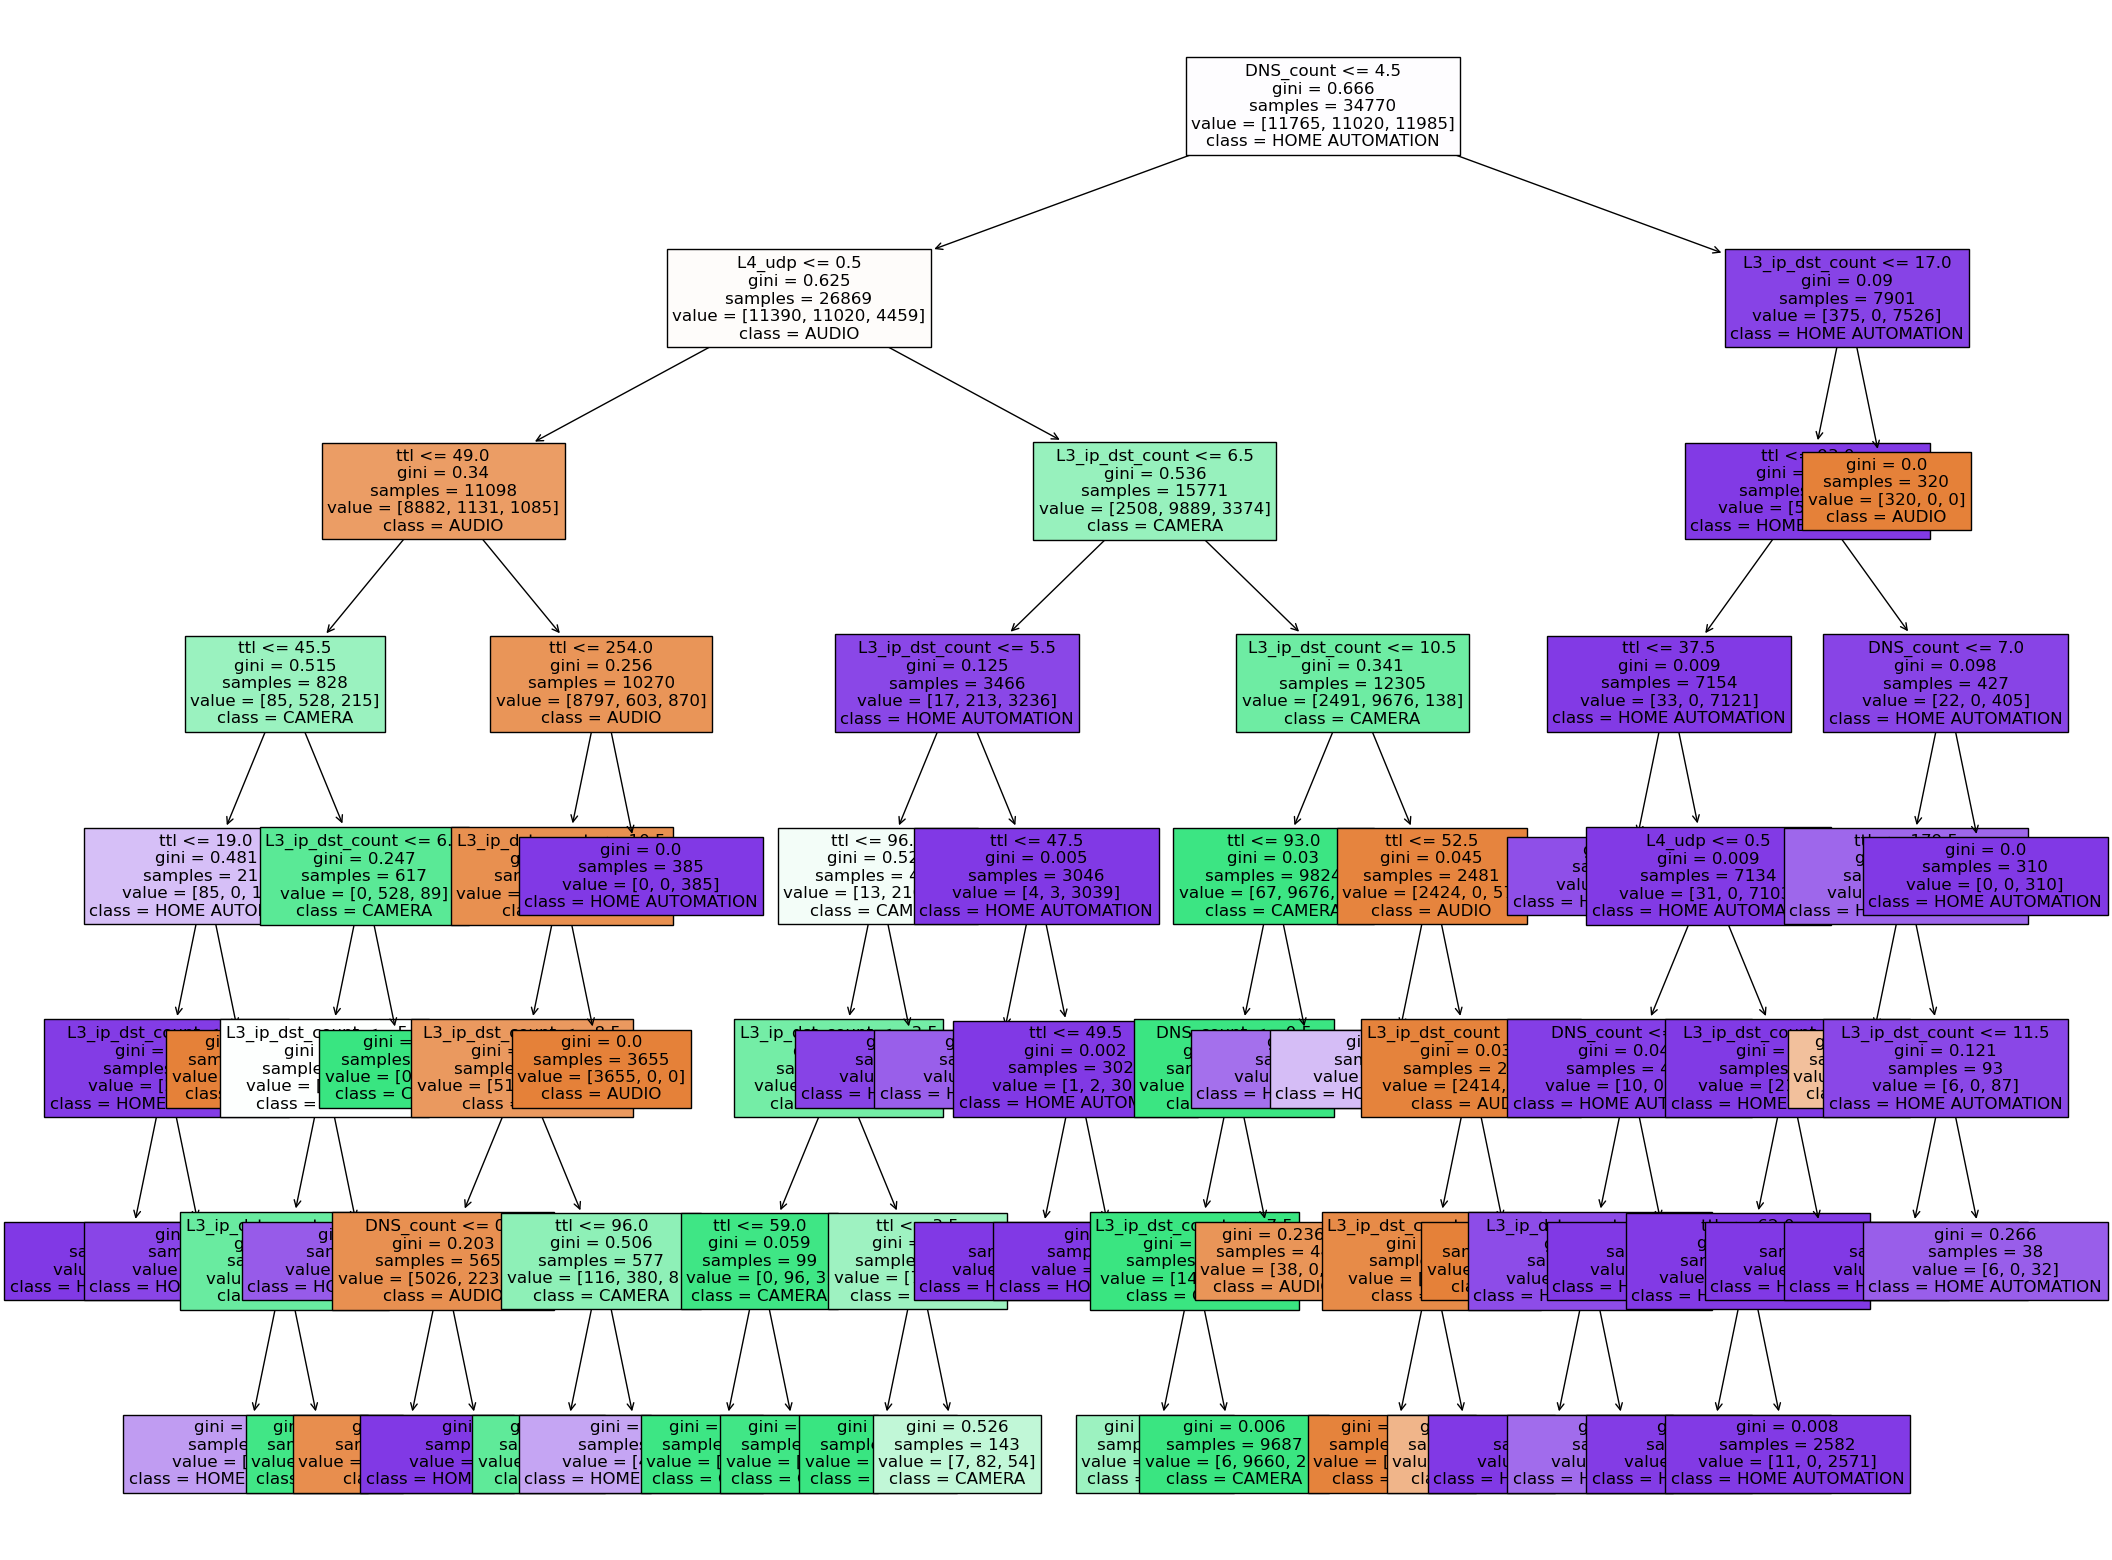

In [430]:
fig = plt.figure(figsize=(25,20))
tree = tree.plot_tree(dt2,
                      feature_names=feature_names_n,
                      class_names={0:'AUDIO', 1:'CAMERA', 2:'HOME AUTOMATION'},
                      filled = True,
                      fontsize = 12)